# 개요

Random Forest를 사용하여 Voting방식으로 재학습에 걸리는 시간과 성능을 체크한다.

* 특징정보 : api
* 수집한 apk : 2014~2020

In [1]:
from tqdm import tqdm
import numpy as np
import os
import pandas as pd
from itertools import product
import time
import warnings
import joblib
import shutil


from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

In [2]:
warnings.filterwarnings(action='ignore')

# 전처리

In [3]:
train_X_dict, train_y_dict, test_X_dict, test_y_dict = dict(),dict(),dict(),dict()
for i, year in enumerate(range(2014,2021)):
    df1 = pd.read_csv(f'./csv_5000/csv_5000/{year}_benign_api.csv', index_col=0)
    df2 = pd.read_csv(f'./csv_5000/csv_5000/{year}_malware_api.csv', index_col=0)
    df1['year']=year
    df1['b/m']=0
    df2['year']=year
    df2['b/m']=1
    
    train_X_dict[year] = pd.concat([df1.iloc[1000:,:-2],df2.iloc[1000:,:-2]])
    train_y_dict[year] = pd.concat([df1.iloc[1000:,-2:],df2.iloc[1000:,-2:]])
    test_X_dict[year] = pd.concat([df1.iloc[:1000,:-2],df2.iloc[:1000,:-2]])
    test_y_dict[year] = pd.concat([df1.iloc[:1000,-2:],df2.iloc[:1000,-2:]])

In [4]:
def make_model(df_x, df_y):
    model = RandomForestClassifier(random_state=42)
    start = time.time()
    model.fit(df_x, df_y)
    end = time.time()
    return model, (end-start)*1000

In [5]:
def model_pred(model_list, test_df):
    return np.argmax(np.sum([model.predict_proba(test_df) for model in model_list], axis=0), axis=1)

In [6]:
def convert_size(size_bytes):
    import math
    if size_bytes == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    i = int(math.floor(math.log(size_bytes, 1024)))
    p = math.pow(1024, i)
    s = round(size_bytes / p, 2)
    return "%s %s" % (s, size_name[i])

In [7]:
def AUT(list_):
    return sum([(list_[i] + list_[i+1])/2 for i, elm in enumerate(list_[:-1])])/(len(list_)-1) 

# Sustainability 실험

In [8]:
dir_path = './ex3_model'

if os.path.exists(dir_path):
    shutil.rmtree(dir_path)

if not os.path.isdir(dir_path):
    os.mkdir(dir_path)

In [9]:
time_list=[]
size_list=[0]
score_dict = dict()
f1_dict = dict()

## 모든 연도 학습

In [10]:
for year in range(2014,2021):
    exec(f"model{year-2000}, train_time = make_model(train_X_dict[year], train_y_dict[year]['b/m'])")
    exec(f"joblib.dump(model{year-2000}, './ex3_model/model{year-2000}.pkl')")
    
    exec(f'time_list.append(({year}, train_time))')
    
    exec(f"f_size = convert_size(sum([os.path.getsize('./ex3_model/'+file) for file in os.listdir('./ex3_model/')]))")
    exec(f'size_list.append(({year}, f_size))')

In [11]:
size_list.remove(0)

## 성능 테스트

In [12]:
for i in range(2014,2021):
    model_list = [eval(f'model{j-2000}') for j in range(2014, i+1)]
    score_list=[]
    f1_list=[]
    for j in range(2014,2021):
        pred = model_pred(model_list, test_X_dict[j])
        score_list.append(accuracy_score(test_y_dict[j]['b/m'], pred))
        f1_list.append(f1_score(test_y_dict[j]['b/m'], pred))
    score_dict[i] = score_list
    f1_dict[i] = f1_list

# 결과

In [13]:
if not os.path.isdir('./visual3'):
    os.mkdir('./visual3')

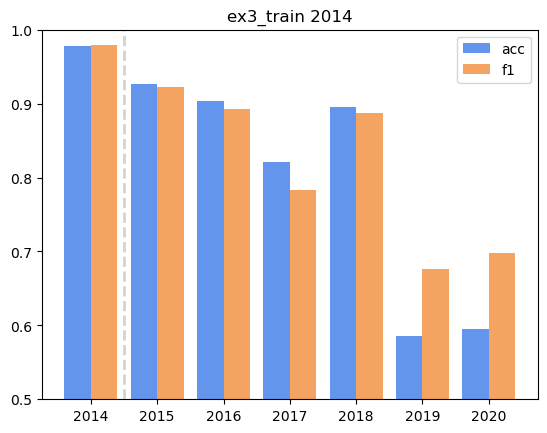

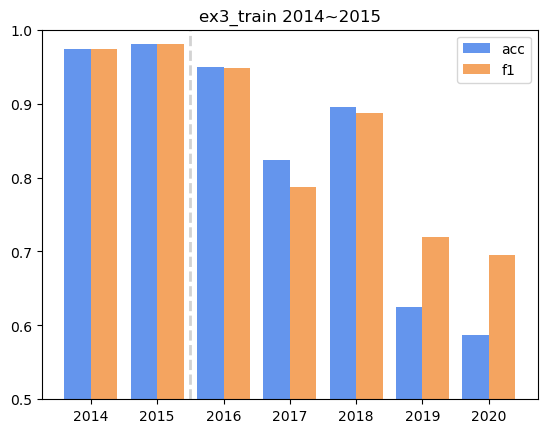

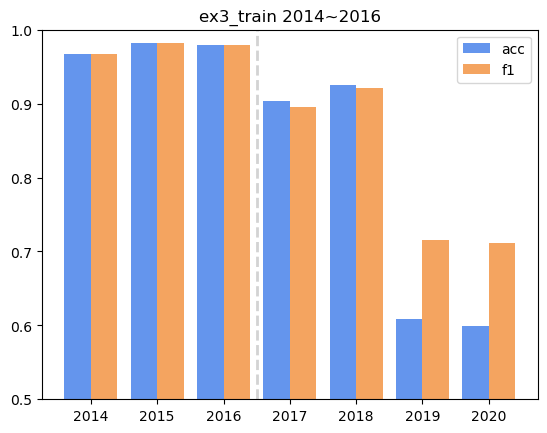

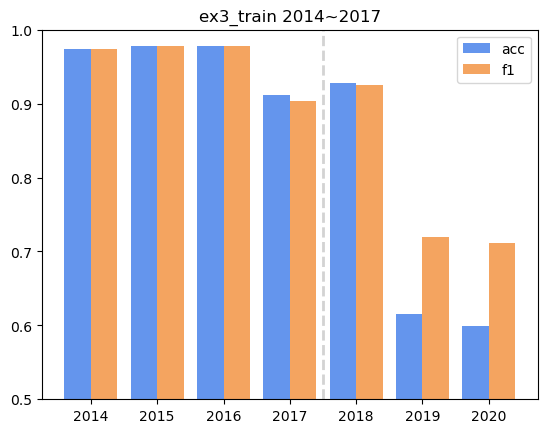

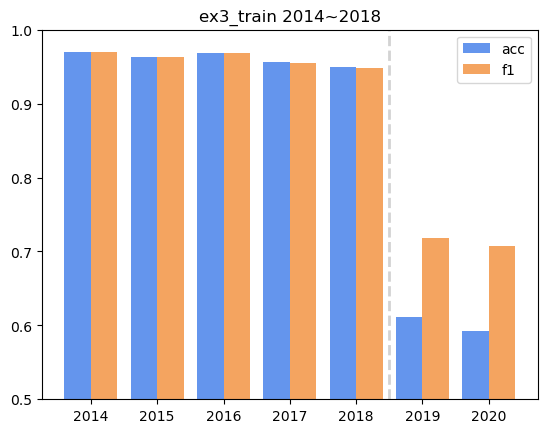

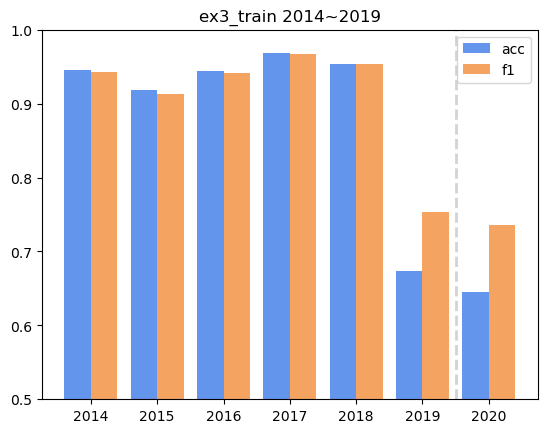

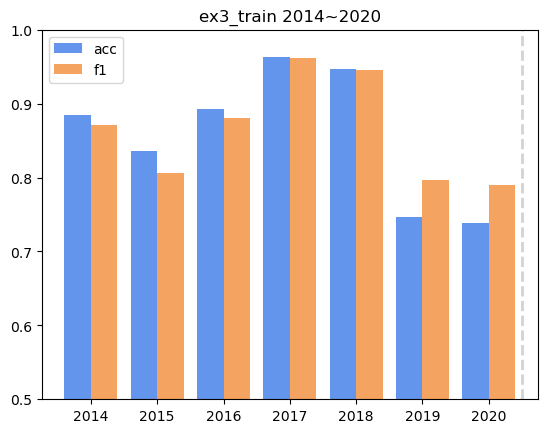

In [14]:
years = range(2014,2021)
x = np.arange(len(years))

for i in range(2014,2021):
    plt.bar(x-0.2 , score_dict[i], label="acc", width=0.4, color='cornflowerblue')
    plt.bar(x+0.2 , f1_dict[i], label="f1", width=0.4, color='sandybrown')
    plt.axvline(i-2013.5, 0, 1, color='lightgray', linestyle='--', linewidth=2)
    if i ==2014:
        plt.title(f'ex3_train 2014')
    else:
        plt.title(f'ex3_train 2014~{i}')
    plt.xticks(x, years)
    plt.ylim(0.5,1)
    plt.legend()
    plt.savefig(f"./visual3/ex3_{i}_acc_f1.png")
    plt.show()

In [15]:
df = pd.concat([
    pd.DataFrame(time_list), 
    pd.DataFrame(size_list)[1], 
    pd.DataFrame([AUT(score_dict[i]) for i in range(2014,2021)]),
    pd.DataFrame([AUT(f1_dict[i]) for i in range(2014,2021)]),
], axis=1)

df.columns=['year','train_time','model_file_size','accuracy','f1 score']
df

,year,train_time,model_file_size,accuracy,f1 score
0,2014,1478.762150,7.86 MB,0.819833,0.833311
1,2015,1531.098366,16.25 MB,0.842750,0.859634
2,2016,1468.998194,23.17 MB,0.863458,0.888700
3,2017,1325.958252,27.84 MB,0.866375,0.891137
4,2018,2238.579512,32.39 MB,0.871667,0.898404
5,2019,1385.416508,35.82 MB,0.875583,0.894629
6,2020,1475.602865,39.06 MB,0.865833,0.870202


In [16]:
df.to_csv('./ex3_result.csv')

In [17]:
print(len(time_list), len(size_list), len(score_dict), len(f1_dict))

7 7 7 7


In [20]:
score_dict[2020]

[0.884, 0.8355, 0.8925, 0.963, 0.947, 0.746, 0.738]

In [21]:
sum(score_dict[2020])/7

0.858